## ```Customer Base Analytics with Recurrent Neural Networks```
```A sequence-to-sequence recurrent neural network model of customer transactions [Valendin et al. 2022].```

example training data from https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions

- create environment: `conda create -y -n tf python==3.9.7`
- activate environment: `source activate tf`
- install requirements: `pip install pandas numpy tqdm tensorflow tensorflow-probability matplotlib jupyter notebook`

### import data

In [1]:
import random
import datetime
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tqdm.auto import tqdm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# load the data from the source file
# only need the account_id (a primary key, customer identifier) and the date columns
# convert the date column from strings like "930101" into a proper datetime format
df = pd.read_csv(filepath_or_buffer='trans.zip', 
                 usecols=['account_id', 'date'], 
                 parse_dates=['date'])

In [2]:
# define the training (calibration) and prediction (holdout) period

training_start = '1993-01-01'
training_end   = '1995-12-31'
holdout_start  = '1996-01-01'
holdout_end    = '1998-12-31'
date_format    = '%Y-%m-%d'

In [3]:
# display basic stats

cohort_accounts = df.groupby('account_id').min().query(
    'date <= @training_end').reset_index()['account_id'].tolist()

df = df.query('account_id in @cohort_accounts')
df = df.sort_values(by='account_id').reset_index(drop=True)

print(f"Accounts in dataset:  {len(df['account_id'].unique())}")
print(f"Total transactions: {len(df)}")

Accounts in dataset:  2239
Total transactions: 744015


### display basic plots

In [4]:
# count aggregate stats

aggregate_counts = df.copy(deep=True)
aggregate_counts['year'] = aggregate_counts['date'].dt.year
aggregate_counts['week'] = (aggregate_counts['date'].dt.dayofyear // 7).clip(upper=51) # we roll the 52nd week into the 51st
aggregate_counts['month'] = aggregate_counts['date'].dt.month - 1
aggregate_counts = aggregate_counts.groupby(['year', 'month', 'week']).agg({'account_id': 'count', 'date': 'min'}).reset_index()

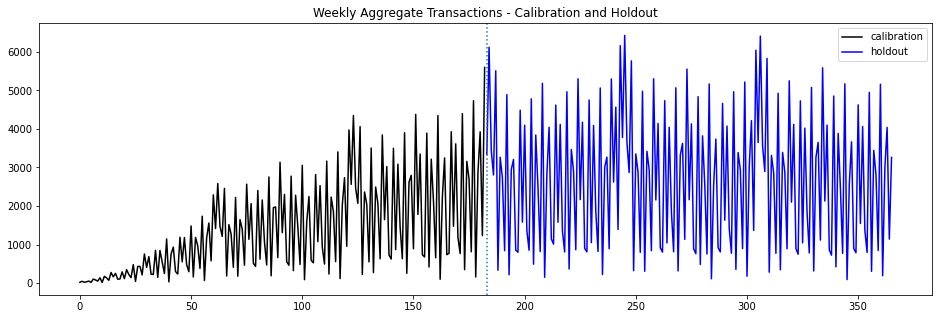

In [5]:
# display aggregate calibration and holdout transactions plot

plt.figure(figsize=(16,5))
plt.plot(aggregate_counts[aggregate_counts.date <= training_end].index, 
         aggregate_counts[aggregate_counts.date <= training_end]['account_id'], color='black', label='calibration')
plt.plot(aggregate_counts[aggregate_counts.date >= holdout_start].index, 
         aggregate_counts[aggregate_counts.date >= holdout_start]['account_id'], color='blue', label='holdout')
plt.axvline(len(aggregate_counts[aggregate_counts.date <= training_end]), linestyle=':')
plt.title('Weekly Aggregate Transactions - Calibration and Holdout')
plt.legend()
plt.savefig("calibration_holdout.png", dpi=600)
plt.show()

# note the prominent monthly pattern with spiky first weeks

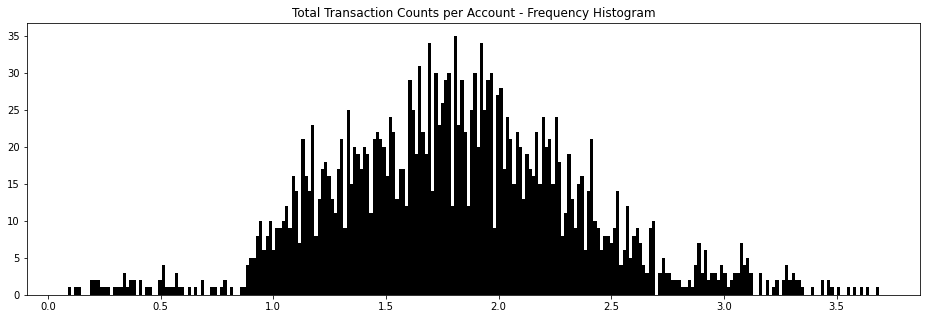

In [66]:
# display the distribution of total transaction counts per customer

transactions_per_account = list(df.groupby('account_id').count()['date'])

plt.figure(figsize=(16,5))
plt.hist(transactions_per_account, bins=250, color='black')
plt.title('Total Transaction Counts per Account - Frequency Histogram')
plt.savefig("transactions_histogram.png", dpi=600)
plt.show()

### training data preparation

In [7]:
# generate a list of dates between two dates
def date_range(start, end):
    start = datetime.datetime.strptime(start, date_format)
    end = datetime.datetime.strptime(end, date_format)
    r = (end+datetime.timedelta(days=1)-start).days
    return [start+datetime.timedelta(days=i) for i in range(r)]

# prepare a template for training samples to be filled with each customer's data
ed = pd.DataFrame(date_range(training_start, holdout_end), columns={'date'})
ed['year'] = ed['date'].dt.year      # 0-indexing 
ed['month'] = ed['date'].dt.month - 1
ed['week'] = (ed['date'].dt.dayofyear // 7).clip(upper=51)

# save the holdout calendar for later use
holdout_calendar = ed[ed['date'] >= holdout_start].drop(columns=['date']).drop_duplicates().drop(columns=['year'])

# samples are training inputs
# targets are training labels
# calibration is stored for later use in prediction
# holdout is data not used in training
samples, targets, calibration, holdout = [], [], [], []
trans = 0 # total transaction count across all individuals

max_trans_per_week = 0
max_trans_cust = []

# shuffle data randomly
ids = df['account_id'].unique()
random.shuffle(ids)

# build a record for each customer
for account in tqdm(ids, desc='preparing dataset'):
    # take the data of single user, 
    subset = df.query('account_id == @account').groupby(
        ['date']).count().reset_index()
    user = subset.copy(deep=True)
    user = user.rename(columns={'account_id': 'transactions'})
    # copy the empty frame
    frame = ed.copy(deep=True)
    # insert customer ID
    frame['account_id'] = account
    # merge customer data into the empty frame
    frame = frame.merge(user, on=['date'], how='left')
    # aggregate weekly transactions
    frame = frame.groupby(['year', 'month', 'week']).agg(
        {'transactions': 'sum', 
         'date': 'min'}).sort_values(['date']).reset_index()
    # there is a small number of ids with 7 and more transactions per week
    # to make the job easier for the model, we can clip the value at 6:
    # frame['transactions'] = frame['transactions'].clip(upper=6)
    # this will however make the assertion following this block fail
    max_trans = max(frame['transactions'])
    max_trans_per_week = max(max_trans_per_week, max_trans)
    max_trans_cust.append(max_trans)
    # keep a count of the total transactions
    trans += user['transactions'].sum()
    # training sequences of everything until the holdout period
    training = frame[frame['date'] < holdout_start]
    training = training.drop(columns=['date', 'year']).astype(int)
    # store for later use
    calibration.append(training)
    # training sample: calibration sequence sans the final element
    sample = training[:-1].values
    samples.append(sample)
    # target labels: sequence of transaction counts starting 
    # with the 2nd element. At each step of the training
    # we use a row from the train_samples element as our input, 
    # and predict the corresponding element from train_targets
    target = training.loc[1:, 'transactions'].values
    targets.append(target)
    # keep holdout sequence to compare with predictions
    hold = frame[frame['date'] >= holdout_start]
    hold = hold.drop(columns='date')
    holdout.append(hold)
       
# check that we didn't lose any transactions along the way
assert trans == len(df)

print(f"Maximum transactions per account_id per time-unit found: {int(max_trans_per_week)}")

# create a validation set which won't be used in training
# we've already shuffled the data so we just grab the tail end
# of the list for validation, the rest is the training set
VALIDATION_SPLIT = 0.1
validation_size = round(len(samples) * VALIDATION_SPLIT)
valid_samples, valid_targets = samples[-validation_size:], targets[-validation_size:]
train_samples, train_targets = samples[:-validation_size], targets[:-validation_size]

def decode_sample(sample, target):
    return ({'month'      : tf.cast(tf.expand_dims(sample[:, 0], axis=-1), 'int32'), 
             'week'       : tf.cast(tf.expand_dims(sample[:, 1], axis=-1), 'int32'), 
             'transaction': tf.cast(tf.expand_dims(sample[:, 2], axis=-1), 'int32')},
             tf.cast(tf.expand_dims(target, axis=-1), 'int32'))

# number of samples in each dataset
no_train_samples, no_valid_samples = len(train_samples), len(valid_samples)

# batch size is the number of samples used to calculate
# the loss gradient at each step during the training
BATCH_SIZE_TRAIN = 32   

# for prediction this doesn't matter appart from memory constraint, 
# if you run out of memory you might need to set this to a smaller value 
BATCH_SIZE_PRED = no_valid_samples  
# validation loss also calculated in one step
BATCH_SIZE_VALID = no_valid_samples

# lenght of each training sequence:
seq_len = samples[0].shape[0]

train_dataset = (tf.data.Dataset.from_tensor_slices((train_samples, train_targets))
                .map(decode_sample)
                .batch(BATCH_SIZE_TRAIN)
                .repeat())

valid_dataset = (tf.data.Dataset.from_tensor_slices((valid_samples, valid_targets))
                 .map(decode_sample).batch(BATCH_SIZE_VALID).repeat())

preparing dataset:   0%|          | 0/2239 [00:00<?, ?it/s]

Maximum transactions per account_id per time-unit found: 11


In [52]:
train_samples[10][:50]

array([[ 0,  0,  0],
       [ 0,  1,  0],
       [ 0,  2,  0],
       [ 0,  3,  0],
       [ 0,  4,  0],
       [ 1,  4,  0],
       [ 1,  5,  0],
       [ 1,  6,  0],
       [ 1,  7,  0],
       [ 1,  8,  0],
       [ 2,  8,  0],
       [ 2,  9,  0],
       [ 2, 10,  0],
       [ 2, 11,  0],
       [ 2, 12,  0],
       [ 3, 13,  0],
       [ 3, 14,  0],
       [ 3, 15,  0],
       [ 3, 16,  0],
       [ 3, 17,  0],
       [ 4, 17,  0],
       [ 4, 18,  0],
       [ 4, 19,  0],
       [ 4, 20,  0],
       [ 4, 21,  0],
       [ 5, 21,  0],
       [ 5, 22,  0],
       [ 5, 23,  0],
       [ 5, 24,  0],
       [ 5, 25,  0],
       [ 6, 26,  0],
       [ 6, 27,  0],
       [ 6, 28,  0],
       [ 6, 29,  0],
       [ 6, 30,  0],
       [ 7, 30,  0],
       [ 7, 31,  0],
       [ 7, 32,  2],
       [ 7, 33,  0],
       [ 7, 34,  1],
       [ 8, 34,  0],
       [ 8, 35,  0],
       [ 8, 36,  2],
       [ 8, 37,  1],
       [ 8, 38,  0],
       [ 8, 39,  1],
       [ 9, 39,  0],
       [ 9, 4

### building the training model

In [8]:
# now let's build the neural network model
# first we need to import a bunch of building blocks

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Lambda

# number of units in the memory layer
memory_units = 128

# number of units in the dense layer
dense_units = 128

# cardinalities of input features
max_month = 12
max_week = 52

# add 1 here since 0 is also a valid weekly transaction count
max_trans = int(max_trans_per_week) + 1  

def emb_size(feature_max: int):
    """ A simple heuristic to determine embedding layer size"""
    return int(feature_max ** 0.5) + 1

""" input layers map directly to the features from 
    the input data: month, week, transactions """
input_month = Input(shape=(seq_len, 1), name='month')
input_week = Input(shape=(seq_len, 1), name='week')
input_transactions = Input(shape=(seq_len, 1), name='transaction')

""" embedding layers compress signal into a dense real-valued 
    vector representation. This helps the model extract useful 
    signals from the input features """
embedding_month = Embedding(max_month, emb_size(max_month), name='embed_month')
embedding_week = Embedding(max_week, emb_size(max_week), name='embed_week')
embedding_transactions = Embedding(max_trans, emb_size(max_trans), name='embed_trans')

# a simple layer that concatenates a list of vectors
concat = Concatenate(axis=-1, name='concat')

# a simple layer that removes a dimension from data tensor 
#  this is needed because the embedding layers introduce 
#  an extra dimension (of size 1), which we do not need
squeeze = Lambda(lambda x: K.squeeze(x, axis=-2), name='squeeze')

""" the LSTM serves as the 'memory' of the model
    we define separate LSTM layers for training and prediction models
    'stateful' LSTM keeps the internal state (memory) until explicitly deleted
    'state-less' LSTM forgets everything after each batch of samples is processed """
training_memory_layer = LSTM(memory_units, return_sequences=True, stateful=False, name='lstm')

""" Dense layers add non-linear compute capacity to the model """
dense_layer = Dense(dense_units, name='dense') # activation=dense_activation, )

""" The final output layer is a softmax prediction layer where
    each neuron represents the probability predicting a given 
    transaction count """
softmax_layer = Dense(max_trans, activation='softmax', name='softmax')

In [9]:
# now we assemble the layers into a complete Model
# first step is to connect the embedding layers with the inputs
emb_month = embedding_month(input_month)
emb_week = embedding_week(input_week)
emb_trans = embedding_transactions(input_transactions)

# we also squeeze out a superfluous dimension from the tensor
emb_month = squeeze(emb_month)
emb_week = squeeze(emb_week)
emb_trans = squeeze(emb_trans)

# now we combine embedded vectors into a single long vector
output = concat([emb_month, emb_week, emb_trans])

# pass the result to the memory layer(s)
output = training_memory_layer(output)

# feed-forward through the dense layer(s)
output = dense_layer(output)

# final softmax layer
output = softmax_layer(output)

# build the training model
training_inputs = [input_month, input_week, input_transactions]
model_train = Model(training_inputs, output)

# print a summary of the network architecture
model_train.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 month (InputLayer)             [(None, 182, 1)]     0           []                               
                                                                                                  
 week (InputLayer)              [(None, 182, 1)]     0           []                               
                                                                                                  
 transaction (InputLayer)       [(None, 182, 1)]     0           []                               
                                                                                                  
 embed_month (Embedding)        (None, 182, 1, 4)    48          ['month[0][0]']                  
                                                                                              

### training the model

In [10]:
# here we define the loss function, the optimizer method
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# use the popular Adam optimizer with all default parameters
optimizer=Adam()

# compile the model to get it ready for training
model_train.compile(loss=sparse_categorical_crossentropy, optimizer=optimizer)

# callbacks are helper functions that control the training flow
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model_weights_filename = 'model_weights.hdf5'

callbacks = [
            # monitor the validation loss and stop training after
            # 'patience' number of epochs during which there is
            # no improvement whatsoever, then restore model weights
            # from the very best epoch afterwards (epoch with the 
            # lowest validation loss
            EarlyStopping(
                monitor='val_loss',
                min_delta=0.,
                restore_best_weights=True,
                # training will stop early if validation loss stops improving for 5 epochs
                patience=5,
                verbose=1,
                mode="auto",
            ),
            # save model parameters to file as long as the model 
            # improves (val_loss decreases)
            ModelCheckpoint(
                model_weights_filename,
                monitor='val_loss',
                save_best_only=True,
                save_weights_only=True,
            )
            ]

# set a maximum of MAX_EPOCHS to limit the training
# This example takes about 100 epochs in total
# Using a dual-core laptop, one epoch takes ~5s
# With a GPU like GeForce 2080, one epoch takes ~1s
MAX_EPOCHS = 150

# start the actual training
# the final validation loss should be around 0.4 with the default hyperparameters
history = model_train.fit(train_dataset, 
                          epochs=MAX_EPOCHS, 
                          verbose=2,
                          shuffle=True,
                          callbacks=callbacks,
                          validation_data=valid_dataset,
                          validation_steps=no_valid_samples//BATCH_SIZE_VALID,
                          steps_per_epoch=no_train_samples//BATCH_SIZE_TRAIN)

Epoch 1/150


2022-02-18 18:43:07.766727: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


62/62 - 8s - loss: 1.3162 - val_loss: 0.9403 - 8s/epoch - 128ms/step
Epoch 2/150
62/62 - 7s - loss: 0.8691 - val_loss: 0.8059 - 7s/epoch - 109ms/step
Epoch 3/150
62/62 - 7s - loss: 0.8164 - val_loss: 0.7590 - 7s/epoch - 106ms/step
Epoch 4/150
62/62 - 7s - loss: 0.7515 - val_loss: 0.6740 - 7s/epoch - 109ms/step
Epoch 5/150
62/62 - 7s - loss: 0.6558 - val_loss: 0.6177 - 7s/epoch - 107ms/step
Epoch 6/150
62/62 - 7s - loss: 0.6303 - val_loss: 0.5983 - 7s/epoch - 112ms/step
Epoch 7/150
62/62 - 7s - loss: 0.6202 - val_loss: 0.5877 - 7s/epoch - 109ms/step
Epoch 8/150
62/62 - 7s - loss: 0.6096 - val_loss: 0.5786 - 7s/epoch - 108ms/step
Epoch 9/150
62/62 - 6s - loss: 0.5984 - val_loss: 0.5655 - 6s/epoch - 101ms/step
Epoch 10/150
62/62 - 7s - loss: 0.5896 - val_loss: 0.5587 - 7s/epoch - 108ms/step
Epoch 11/150
62/62 - 7s - loss: 0.5812 - val_loss: 0.5554 - 7s/epoch - 107ms/step
Epoch 12/150
62/62 - 7s - loss: 0.5746 - val_loss: 0.5525 - 7s/epoch - 107ms/step
Epoch 13/150
62/62 - 6s - loss: 0.569

#### The final validation loss should end up around 0.39 after ±90 epochs with the default parameters

### build prediction model

In [11]:
# the prediction model is almost identical to the training model
# the one difference is that instead of a probability distribution
# output, we use a sampling layer to create realizations to simulate
# alternative future scenarios

def sample_multinomial(probs):
    """
    Draws a sample of length 1 from a multinomial distribution with the
    given class probabilities.
    """

    return tf.cast(
        tf.expand_dims(
            tfp.distributions.Categorical(probs=probs).sample(), axis=-1
        ),
        dtype=K.floatx(),
    )

# sample values from softmax multinomial distribution
sample_layer = Lambda(sample_multinomial, name="sample_transactions")

""" Another difference is that we use a "stateful" LSTM layer for prediction.
    This layer has the exact same size as the LSTM we used in the training model,
    hence the same number of parameters, and we will literally copy the parameters
    over from the training model. The "stateful" property means that the internal
    cell state - the "memories" of the layer - are kept until we explicitly delete
    them. In trainin those are reset to 0 after each sequence is processed - we're 
    learning from independent histories, so keeping the memories doesn't make sense
    there. In prediction however, we need a bit of fine control: we will be feeding
    new inputs into the model step by step, so we will also be carefully managing the
    memory content ourselves.
"""

prediction_memory_layer = LSTM(memory_units, return_sequences=True, stateful=True, name='lstm')

# we use a separate set of Input objects for prediction since the shape of 
# data is different: 
# the first dimension is the BATCH_SIZE_PRED
# the second dimension is NONE because instead of knowing the length of the 
# sequence beforehand we want the model to accept sequences of arbitrary length
# the last dimension is 1 (1 scalar value per timestep per feature)

p_input_month = Input(batch_shape=(BATCH_SIZE_PRED, None, 1), name='month')
p_input_week = Input(batch_shape=(BATCH_SIZE_PRED, None, 1), name='week')
p_input_transactions = Input(batch_shape=(BATCH_SIZE_PRED, None, 1), name='transaction')

# reuse the pretrained embeddings
emb_month = embedding_month(p_input_month)
emb_week = embedding_week(p_input_week)
emb_trans = embedding_transactions(p_input_transactions)

# squeeze out a superfluous dimension from the tensor like before
emb_month = squeeze(emb_month)
emb_week = squeeze(emb_week)
emb_trans = squeeze(emb_trans)

# combine embedded vectors into a single vector
output = concat([emb_month, emb_week, emb_trans])

# apply the prediction memory layer
output = prediction_memory_layer(output)

# feed-forward through the dense layers
output = dense_layer(output)

# softmax layer
output = softmax_layer(output)

# apply final sampling layer
output = sample_layer(output)

# build the prediction model
prediction_inputs = [p_input_month, p_input_week, p_input_transactions]
model_pred = Model(prediction_inputs, output)

# the training and prediction models have the exact same number of parameters
assert model_pred.count_params() == model_train.count_params()

# check if model has already been trained
import os.path
if not os.path.exists(model_weights_filename) and os.path.isfile(model_weights_filename):
    print('please go back and train a model first')

# load model parameters from training model to the prediction model
model_pred.load_weights(model_weights_filename, by_name=True)

### prepare prediction seed

In [12]:
# before we can start forecasting, we feed in the entire previous history
# for each individual, to build up the cell-state memory which represents
# each individual past history. After we feed in the last element of the 
# training sequence, the model output will be the first forecasted value
# for the holdout period. To make things easy, we first put all calibration
# data into a individuals*sequence_length*number_of_features shaped tensor.
# We call this object "the seed".

seed = np.array([df.values for df in calibration], dtype=np.float32)
print(f"The seed shape is individuals ({seed.shape[0]}) X calibration length ({seed.shape[1]}) X number of features ({seed.shape[2]})")

no_samples = seed.shape[0]
no_timesteps = seed.shape[1]
no_features = seed.shape[2]
no_batches = int(np.ceil(no_samples/BATCH_SIZE_PRED))

# pad the last batch with 0s if needed and then 
# remove the corresponding predictions after we're done predicting
if seed.shape[0] < (BATCH_SIZE_PRED * no_batches):
    padding = np.zeros(((BATCH_SIZE_PRED * no_batches) - no_samples, no_timesteps, no_features))
    seed = np.concatenate((seed, padding), axis=0)

The seed shape is individuals (2239) X calibration length (183) X number of features (3)


### generate predictions

In [18]:
# simulate several independent scenarios 
# we take the mean to remove sampling noise
# most improvement with 20-30 independent simulations
# generating one scenario takes about 2mins on dual-core laptop
# simulated scenarios can be generated in parallel
NO_SCENARIOS = 3


scenarios = []
# how many time-steps does the holdout have
holdout_length = holdout[0].shape[0]

for _ in tqdm(range(NO_SCENARIOS), desc='simulating scenarios'):
    batches_predicted = []

    for j in range(no_batches):
        pred = []
        # in the beginning reset the model memory
        model_pred.reset_states()
        
        # calculate batch start and end indexes
        batch_start = j * BATCH_SIZE_PRED
        batch_end = (j + 1) * BATCH_SIZE_PRED
        # batch is a dictionary which links model inputs with lists of sample features
        batch = {}        
        batch['month'] = seed[batch_start:batch_end, :, 0:1]
        batch['week'] = seed[batch_start:batch_end, :, 1:2]
        batch['transaction'] = seed[batch_start:batch_end, :, 2:3]        
        # pass the batch through the prediction model: here we discard the output
        # since we're not interested in in-sample prediction (maybe you are?), we
        # just need to build up that internal cell-state memory
        prediction = model_pred.predict(batch, batch_size=BATCH_SIZE_PRED)                
        # we do however take the very last element of each predicted sequence: 
        # as this is the first forecasted value
        pred.append(prediction[:, -1:, :])

        # now lets forecast all the future steps autoregressively
        for i in range(holdout_length - 1):
            batch = []
            for calendar_feature in ['month', 'week']:                        
                feature = np.repeat(holdout_calendar.iloc[i][calendar_feature], BATCH_SIZE_PRED)
                batch.append(feature[:, np.newaxis, np.newaxis])
            batch.append(pred[-1])
            
            prediction = model_pred.predict(batch, batch_size=BATCH_SIZE_PRED)
            pred.append(prediction[:, -1:, :])
            
        batches_predicted.append(pred)

    scenarios.append(batches_predicted)

z = []
for scenario in scenarios:
    y = []
    for batch in scenario:
        x = []
        for time_step in batch:
            if type(time_step) == np.ndarray:
                x.append(time_step)
            else:
                complete_time_step = np.concatenate(time_step, axis=-1)
                x.append(complete_time_step)
        y.append(np.concatenate(x, axis=1))
    # cut off the padding, if any
    z.append(np.concatenate(y, axis=0)[:no_samples, :, :])

# predictions is a multidimensional array holding all the predicted values
predictions = np.asarray(z)

# use the index from holdout to create output in the right shape
predicted_holdout = holdout[0]

# take the mean across multiple simulations to create the final prediction
predicted_holdout['transactions'] = np.squeeze(np.sum(np.mean(predictions, axis=0), axis=0))
predicted_holdout = predicted_holdout['transactions'].reset_index()

simulating scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

In [63]:
# individual predictions are stored as a table where rows are indexed with customer ids 
# and columns represent the predicted transaction counts over the weekly holdout periods

individual_predictions = pd.DataFrame(np.squeeze(np.mean(predictions, axis=0))).round(2).set_index(pd.Series(df['account_id'].unique()))

print('first 5 predicted individuals:\n')
print(individual_predictions.head())

first 5 predicted individuals:

    0     1     2     3     4    5     6     7     8     9    ...   173   174  \
1  1.33  2.00  1.33  0.33  3.33  0.0  2.00  1.00  0.00  3.00  ...  0.33  1.67   
2  1.33  3.33  1.67  3.33  2.67  0.0  0.67  2.00  0.00  2.00  ...  0.00  1.00   
6  1.33  3.00  1.67  1.00  2.33  0.0  4.67  0.67  0.67  2.33  ...  0.33  2.67   
8  0.67  4.00  2.33  2.33  2.67  0.0  0.00  2.67  0.00  2.00  ...  0.00  1.00   
9  0.00  4.33  0.33  1.33  3.33  0.0  1.67  2.00  0.33  2.00  ...  0.00  2.00   

    175   176   177  178   179   180   181   182  
1  1.67  0.33  2.00  0.0  1.67  2.00  0.67  2.33  
2  1.33  0.00  2.00  0.0  1.00  2.00  1.00  2.33  
6  2.33  0.00  2.67  0.0  1.33  4.67  0.00  2.33  
8  1.33  0.00  2.00  0.0  1.00  2.00  0.33  3.00  
9  0.67  0.67  2.33  0.0  1.67  0.67  1.33  2.33  

[5 rows x 183 columns]


#### We can take one of the generated simulations and examine it as a potential "what-if" scenario. All generated scenarios are equally likely to occur, which is why we use the mean prediction as our final forecast.

In [64]:
one_scenario = pd.DataFrame(np.squeeze(predictions[0])).astype(int).set_index(pd.Series(df['account_id'].unique()))
print('print first 5 predicted individuals in first scenario:\n')
print(one_scenario.head())

print first 5 predicted individuals in first scenario:

   0    1    2    3    4    5    6    7    8    9    ...  173  174  175  176  \
1    1    3    3    1    4    0    2    1    0    3  ...    1    2    1    1   
2    1    2    3    1    4    0    1    3    0    2  ...    0    1    2    0   
6    1    3    1    0    2    0    5    1    0    2  ...    1    4    0    0   
8    1    4    2    2    3    0    0    2    0    2  ...    0    1    1    0   
9    0    3    0    1    5    0    1    2    0    2  ...    0    2    1    0   

   177  178  179  180  181  182  
1    2    0    3    1    1    2  
2    2    0    0    3    2    2  
6    3    0    2    4    0    3  
8    2    0    2    1    0    3  
9    3    0    2    1    1    3  

[5 rows x 183 columns]


##### In this simulated scenario, the first four customers all make one purchase during the first week of the predicted holdout, while the fifth does no business with the firm during that first time period. We can calculate the predicted transaction counts per customer at this point easily, and compare with actuals.

(2239, 183, 1)

### display aggregate forecast

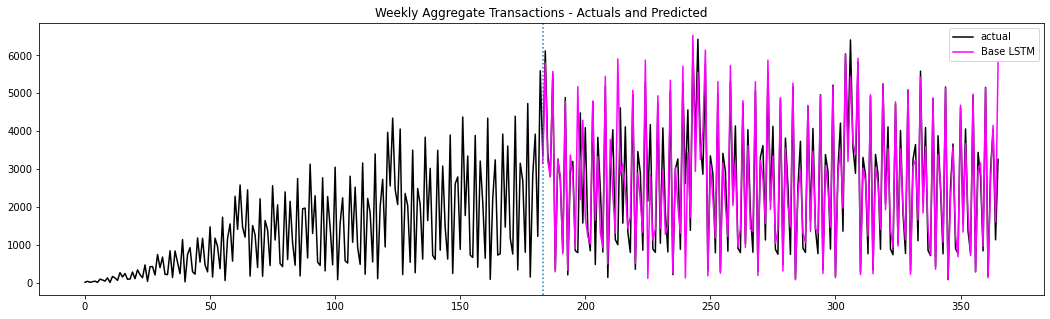

In [14]:
# plot calibration and holdout with prediction

plt.figure(figsize=(18,5))
plt.plot(aggregate_counts.index, aggregate_counts['account_id'], color='black', label='actual')
plt.plot(predicted_holdout['index'], predicted_holdout['transactions'], color='magenta', label='Base LSTM')
plt.axvline(len(aggregate_counts[aggregate_counts.date <= training_end]), linestyle=':')
plt.title('Weekly Aggregate Transactions - Actuals and Predicted')
plt.legend()
plt.savefig("actuals_prediction.png", dpi=600)
plt.show()

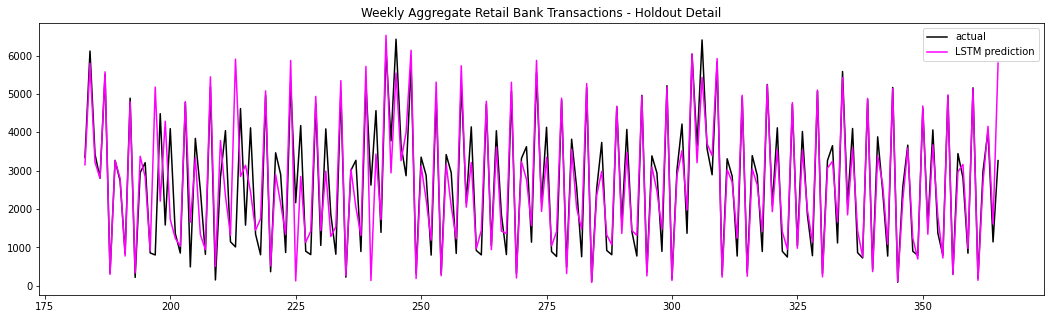

In [15]:
# show holdout with prediction only

plt.figure(figsize=(18,5))
plt.plot(aggregate_counts[aggregate_counts.date >= holdout_start].index, 
         aggregate_counts[aggregate_counts.date >= holdout_start]['account_id'], color='black', label='actual')
plt.plot(predicted_holdout['index'], predicted_holdout['transactions'], color='magenta', label='LSTM prediction')
plt.title('Weekly Aggregate Retail Bank Transactions - Holdout Detail')
plt.legend()
plt.show()

In [16]:
# calculate aggregate bias

actual_holdout = sum(aggregate_counts['account_id'][-len(predicted_holdout['index']):])
bias = (100*(predicted_holdout['transactions'].sum() - actual_holdout)/actual_holdout)
print(f"prediction bias: {bias:.2f} %")

prediction bias: -0.54 %


#### The prediction bias should be around 0.5-1%

#### The model is very capable to capture the overall transaction volumes, which allows for a low predictive bias. In this scenario, the result is extremely good due to the individuals in this scenario transacting in very strong seasonal patterns. Together with the high frequency of transactions, this is an example of a scenario where the LSTM model learns very easilly.